# Лабораторная работа 5: Обучение и тестирование модели

Импортируем библиотеки

In [152]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression


Читаем файл с данными о погоде

In [153]:
df = pd.read_csv('weather.csv')

df = df.set_index(['Дата'])
df = df.rename(columns={'Температура': 'value'})

df.index = pd.to_datetime(df.index)

Создаём функцию временной задержки для данного DataFrame

In [154]:
def generate_time_lags(df: pd.DataFrame, n_lags: int) -> pd.DataFrame:
    """
    Generate time lag features for a given DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the time series data.
        n_lags (int): The number of lag features to generate.

    Returns:
        pd.DataFrame: The DataFrame with lag features.
    """
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["value"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

Разделяем DataFrame на функции и метки

In [155]:
def feature_label_split(df: pd.DataFrame, target_col: str) -> tuple:
    """
    Split the DataFrame into features and labels.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        target_col (str): The column name of the target variable.

    Returns:
        tuple: A tuple containing features (X) and labels (y).
    """
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

Разделяем DataFrame на обучающие, проверочные и тестовые наборы.

In [156]:
def train_val_test_split(df: pd.DataFrame, target_col: str, test_ratio: float) -> tuple:
    """
    Split the DataFrame into training, validation, and test sets.

    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        target_col (str): The column name of the target variable.
        test_ratio (float): The ratio of the test set.

    Returns:
        tuple: A tuple containing training, validation, and test sets for features and labels.
    """
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

Инициализация временной задержки и разделение на обучающую, валидационную и тестовую выборки

In [157]:
input_dim = 100

df_timelags = generate_time_lags(df, input_dim)

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_timelags, 'value', 0.2)

C:\Users\pudov\AppData\Local\Temp\ipykernel_19696\2467995181.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_n[f"lag{n}"] = df_n["value"].shift(n)


Проверка правильности разделения 

In [158]:
def check_balance(y: pd.Series) -> bool:
    """
    Check the balance of a binary target variable.

    Args:
        y (pd.Series): The target variable.

    Returns:
        bool: True if the target variable is balanced, False otherwise.
    """
    class_counts = y.value_counts()
    balance_check = abs(class_counts[0] - class_counts[1]) / len(y) < 0.1
    return balance_check

In [159]:
print("Balance Check - Train Set:", check_balance(y_train), len(y_train))
print("Balance Check - Validation Set:", check_balance(y_val), len(y_val))
print("Balance Check - Test Set:", check_balance(y_test), len(y_test))

Balance Check - Train Set: True 3415
Balance Check - Validation Set: True 1139
Balance Check - Test Set: True 1139


Получение объекта масштабатора

In [160]:
def get_scaler(scaler: str) -> StandardScaler:
    """
    Get a scaler object based on the specified scaler type.

    Args:
        scaler (str): The type of scaler.

    Returns:
        sklearn.preprocessing: The scaler object.
    """
    scalers = {
        "minmax": MinMaxScaler,
        "standard": StandardScaler,
        "maxabs": MaxAbsScaler,
        "robust": RobustScaler,
    }
    return scalers.get(scaler.lower())()

scaler = get_scaler('minmax')

Масштабирование данных для лучшей обучаемости нейросети

In [161]:
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

Преобразования массивов данных в тензоры для обучения нейросети

In [162]:
train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

Создание датасетов для обучения 

In [163]:
train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

Создаются объекты типа DataLoader для удобной передачи данных в модель

In [164]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

Тут задаются параметры модели
input_dim: Количество узлов во входном слое
output_dim: Количество узлов в выходном слое
hidden_dim: Количество узлов в скрытом слое
layer_dim: Количество слоев
batch_size: Размер батча данных, который будет использоваться в процессе обучения
dropout: Вероятность отключения узлов в процессе обучения
n_epochs: Количество эпох обучения
learning_rate: Скорость обучения для оптимизатора Adam
weight_decay: Коэффициент регуляризации для управления переобучением
model_params: Словарь, содержащий параметры модели

In [165]:
input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 20
learning_rate = 1e-3
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim': hidden_dim,
                'layer_dim': layer_dim,
                'output_dim': output_dim,
                'dropout_prob': dropout}

Этот класс описывает рекуррентную нейронную сеть

In [166]:
class RNNModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int, dropout_prob: float):
        """
        Initialize an RNN model.

        Args:
            input_dim (int): The number of nodes in the input layer.
            hidden_dim (int): The number of nodes in each layer.
            layer_dim (int): The number of layers in the network.
            output_dim (int): The number of nodes in the output layer.
            dropout_prob (float): The probability of nodes being dropped out.
        """
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the RNN model.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor.
        """
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()
        out, h0 = self.rnn(x, h0.detach())
        out = out[:, -1, :]
        out = self.fc(out)
        return out

Этот класс позваляет обучать модель, оценивать и визуализировать её работу

In [167]:
class Optimization:
    def __init__(self, model: nn.Module, loss_fn: nn.Module, optimizer: optim.Optimizer):
        """
        Initialize the optimization object.

        Args:
            model (nn.Module): The neural network model.
            loss_fn (nn.Module): The loss function.
            optimizer (optim.Optimizer): The optimizer.
        """
        self.model = model.to(device)
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x: torch.Tensor, y: torch.Tensor) -> float:
        """
        Perform one step of training.

        Args:
            x (torch.Tensor): The input tensor.
            y (torch.Tensor): The target tensor.

        Returns:
            float: The training loss.
        """
        self.model.train()
        self.optimizer.zero_grad()
        yhat = self.model(x)
        loss = self.loss_fn(y, yhat)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train(self, train_loader: DataLoader, val_loader: DataLoader, batch_size: int = 64,
              n_epochs: int = 50, n_features: int = 1):
        """
        Train the model.

        Args:
            train_loader (DataLoader): DataLoader for the training set.
            val_loader (DataLoader): DataLoader for the validation set.
            batch_size (int): Batch size.
            n_epochs (int): Number of epochs.
            n_features (int): Number of input features.
        """
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) or (epoch % 50 == 0):
                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

    def evaluate(self, test_loader: DataLoader, batch_size: int = 1, n_features: int = 1) -> tuple:
        """
        Evaluate the model on the test set.

        Args:
            test_loader (DataLoader): DataLoader for the test set.
            batch_size (int): Batch size.
            n_features (int): Number of input features.

        Returns:
            tuple: A tuple containing predictions and true values.
        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())
        return predictions, values

    def plot_losses(self, lr: float, bs: int):
        """
        Plot training and validation losses and save the plot with LR and BS in the title.

        Args:
            lr (float): Learning rate.
            bs (int): Batch size.
        """
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title(f"Losses (LR={lr}, BS={bs})")
        plt.savefig(f"losses_LR_{lr}_BS_{bs}.png")  # Save the plot with LR and BS in the filename
        plt.show()
        plt.close()

Обратное преобразование с использованием указанного масштаба для улучшения обучения модели

In [168]:
def inverse_transform(scaler, df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Inverse transform scaled columns using the specified scaler.

    Args:
        scaler: The scaler object used for transformation.
        df (pd.DataFrame): The DataFrame containing the scaled columns.
        columns (list): List of column names to inverse transform.

    Returns:
        pd.DataFrame: The DataFrame with inverse transformed columns.
    """
    df[columns] = scaler.inverse_transform(df[columns])
    return df

Соотношение прогнозов и истенных значений 

In [169]:
def format_predictions(predictions, values, df_test: pd.DataFrame, scaler) -> pd.DataFrame:
    """
    Format predictions and true values into a DataFrame.

    Args:
        predictions: Predicted values.
        values: True values.
        df_test (pd.DataFrame): The original DataFrame for index information.
        scaler: Scaler object used for transformation.

    Returns:
        pd.DataFrame: Formatted DataFrame with 'value' and 'prediction' columns.
    """
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"value": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, ["value", "prediction"])
    return df_result

Вычисление метрик эффективности модели 

In [170]:
def calculate_metrics(df: pd.DataFrame) -> dict:
    """
    Calculate evaluation metrics for a DataFrame with 'value' and 'prediction' columns.

    Args:
        df (pd.DataFrame): DataFrame with 'value' and 'prediction' columns.

    Returns:
        dict: Dictionary containing calculated metrics ('mae', 'rmse', 'r2').
    """
    result_metrics = {'mae': mean_absolute_error(df.value, df.prediction),
                      'rmse': mean_squared_error(df.value, df.prediction) ** 0.5,
                      'r2': r2_score(df.value, df.prediction)}

    print("Mean Absolute Error:       ", result_metrics["mae"])
    print("Root Mean Squared Error:   ", result_metrics["rmse"])
    print("R^2 Score:                 ", result_metrics["r2"])
    return result_metrics

Эксперименты тренеровки с разными значениями learning_rates и batch_sizes


Experiment with Learning Rate=0.001 and Batch Size=16
[1/20] Training loss: 0.0581	 Validation loss: 0.0111
[2/20] Training loss: 0.0136	 Validation loss: 0.0200
[3/20] Training loss: 0.0189	 Validation loss: 0.0358
[4/20] Training loss: 0.0113	 Validation loss: 0.0122
[5/20] Training loss: 0.0166	 Validation loss: 0.0379
[6/20] Training loss: 0.0191	 Validation loss: 0.0151
[7/20] Training loss: 0.0108	 Validation loss: 0.0055
[8/20] Training loss: 0.0137	 Validation loss: 0.0106
[9/20] Training loss: 0.0140	 Validation loss: 0.0068
[10/20] Training loss: 0.0105	 Validation loss: 0.0080
Mean Absolute Error:        4.6113153
Root Mean Squared Error:    5.705506378889676
R^2 Score:                  0.8385014556059114


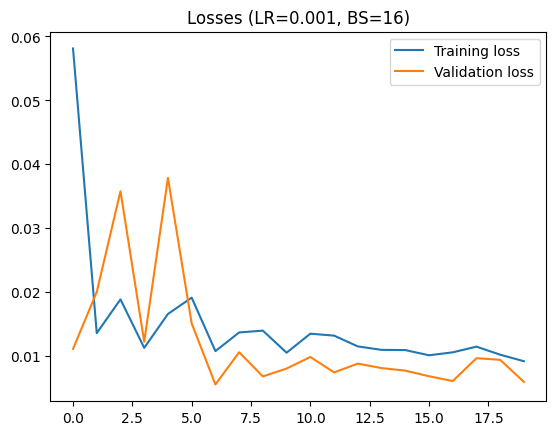

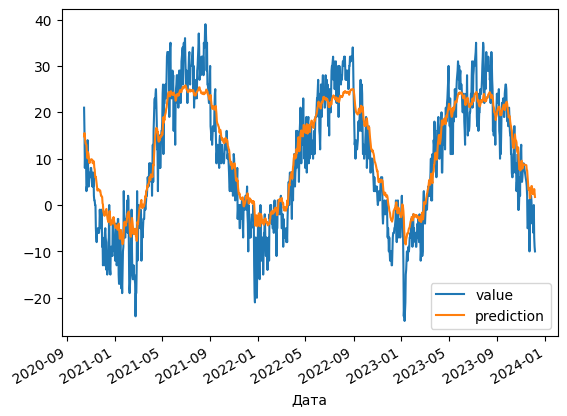


Experiment with Learning Rate=0.001 and Batch Size=32
[1/20] Training loss: 0.0359	 Validation loss: 0.0082
[2/20] Training loss: 0.0131	 Validation loss: 0.0126
[3/20] Training loss: 0.0144	 Validation loss: 0.0050
[4/20] Training loss: 0.0111	 Validation loss: 0.0098
[5/20] Training loss: 0.0127	 Validation loss: 0.0054
[6/20] Training loss: 0.0107	 Validation loss: 0.0060
[7/20] Training loss: 0.0103	 Validation loss: 0.0056
[8/20] Training loss: 0.0125	 Validation loss: 0.0053
[9/20] Training loss: 0.0091	 Validation loss: 0.0058
[10/20] Training loss: 0.0086	 Validation loss: 0.0053
Mean Absolute Error:        3.9582016
Root Mean Squared Error:    4.894927353597505
R^2 Score:                  0.8811298660623366


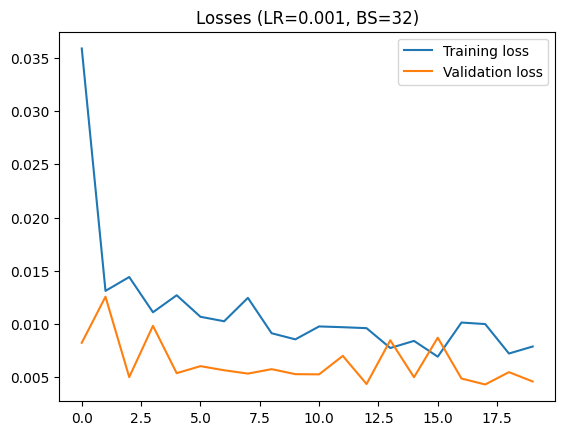

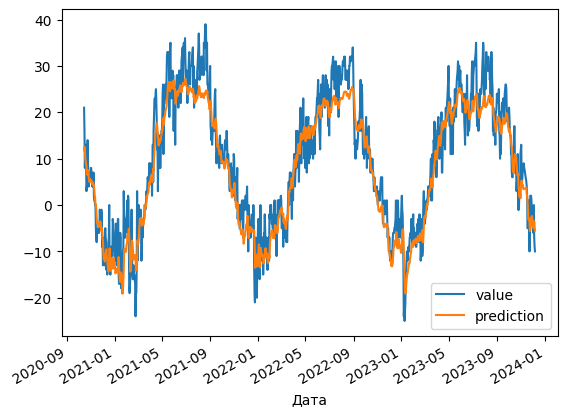


Experiment with Learning Rate=0.001 and Batch Size=64
[1/20] Training loss: 0.0519	 Validation loss: 0.0074
[2/20] Training loss: 0.0121	 Validation loss: 0.0053
[3/20] Training loss: 0.0095	 Validation loss: 0.0051
[4/20] Training loss: 0.0098	 Validation loss: 0.0055
[5/20] Training loss: 0.0083	 Validation loss: 0.0048
[6/20] Training loss: 0.0101	 Validation loss: 0.0100
[7/20] Training loss: 0.0090	 Validation loss: 0.0054
[8/20] Training loss: 0.0105	 Validation loss: 0.0070
[9/20] Training loss: 0.0080	 Validation loss: 0.0051
[10/20] Training loss: 0.0068	 Validation loss: 0.0043
Mean Absolute Error:        3.4579673
Root Mean Squared Error:    4.305443117594607
R^2 Score:                  0.9080363950590986


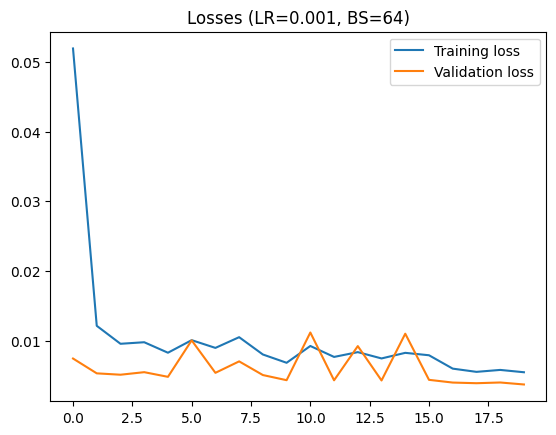

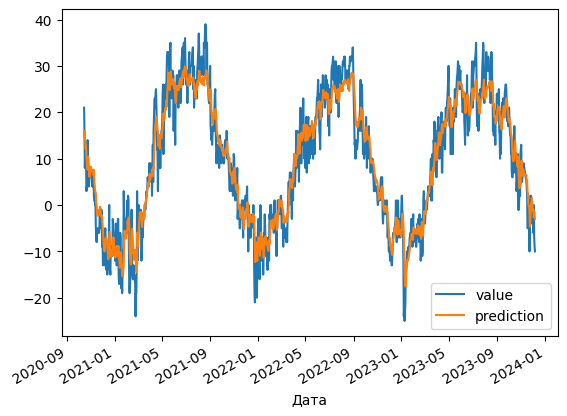


Experiment with Learning Rate=0.0001 and Batch Size=16
[1/20] Training loss: 0.0453	 Validation loss: 0.0116
[2/20] Training loss: 0.0174	 Validation loss: 0.0053
[3/20] Training loss: 0.0120	 Validation loss: 0.0050
[4/20] Training loss: 0.0105	 Validation loss: 0.0050
[5/20] Training loss: 0.0097	 Validation loss: 0.0048
[6/20] Training loss: 0.0092	 Validation loss: 0.0048
[7/20] Training loss: 0.0086	 Validation loss: 0.0047
[8/20] Training loss: 0.0082	 Validation loss: 0.0046
[9/20] Training loss: 0.0082	 Validation loss: 0.0046
[10/20] Training loss: 0.0081	 Validation loss: 0.0044


In [ ]:
model = RNNModel(**model_params)

device = "cpu"

loss_fn = nn.MSELoss(reduction="mean")

learning_rates = [1e-3, 1e-4, 1e-5]
batch_sizes = [16, 32, 64]

results = {}
# experiments with learning_rates and batch_sizes
for lr in learning_rates:
    for bs in batch_sizes:
        print(f"\nExperiment with Learning Rate={lr} and Batch Size={bs}")

        model = RNNModel(**model_params)
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)

        train_loader = DataLoader(train, batch_size=bs, shuffle=False, drop_last=True)
        val_loader = DataLoader(val, batch_size=bs, shuffle=False, drop_last=True)
        test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

        opt.train(train_loader, val_loader, batch_size=bs, n_epochs=n_epochs, n_features=input_dim)

        predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
        df_result = format_predictions(predictions, values, X_test, scaler)

        experiment_name = f"LR={lr}_BS={bs}"
        results[experiment_name] = {
            'metrics': calculate_metrics(df_result),
            'model': model.state_dict(),
        }

        opt.plot_losses(lr=lr, bs=bs)
        torch.save(opt.model.state_dict(), f"trained_model_LR_{lr}_BS_{bs}.pth")
        df_result.plot()
        plt.show()

Вывод метрик каждой модели

In [142]:
for experiment_name, metrics_dict in results.items():
    print(f"\nMetrics for experiment {experiment_name}:")
    for metric_name, metric_value in metrics_dict['metrics'].items():
        print(f"{metric_name}: {metric_value}")


Metrics for experiment LR=0.001_BS=16:
mae: 5.1398024559021
rmse: 6.285849031019715
r2: 0.8039764965288367

Metrics for experiment LR=0.001_BS=32:
mae: 3.75887393951416
rmse: 4.647551123474867
r2: 0.8928410142460195

Metrics for experiment LR=0.001_BS=64:
mae: 3.6426613330841064
rmse: 4.497833154117146
r2: 0.8996339259378879

Metrics for experiment LR=0.0001_BS=16:
mae: 3.589569091796875
rmse: 4.451322277653152
r2: 0.901698906528966

Metrics for experiment LR=0.0001_BS=32:
mae: 3.89316463470459
rmse: 4.884732044566703
r2: 0.8816245191131998

Metrics for experiment LR=0.0001_BS=64:
mae: 4.127192974090576
rmse: 5.156143279849665
r2: 0.8681044274827334

Metrics for experiment LR=1e-05_BS=16:
mae: 4.401015281677246
rmse: 5.507833797332495
r2: 0.8494981281315177

Metrics for experiment LR=1e-05_BS=32:
mae: 6.834194183349609
rmse: 8.20531732237333
r2: 0.6659810963000015

Metrics for experiment LR=1e-05_BS=64:
mae: 8.787805557250977
rmse: 10.298115263411827
r2: 0.473866743857986


Использование уже сохранённых весов для модели

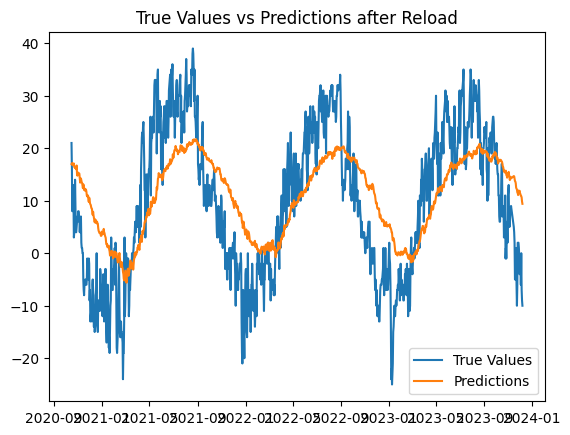

In [147]:
model_after_reload = RNNModel(**model_params)

loaded_model_path = "trained_model_LR_0.001_BS_64.pth"
model_after_reload.load_state_dict(torch.load(loaded_model_path))
model_after_reload.eval()

with torch.no_grad():
    test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)
    predictions_after_reload, values_after_reload = opt.evaluate(test_loader_one, batch_size=1,
                                                                 n_features=input_dim)
    df_result_after_reload = format_predictions(predictions_after_reload, values_after_reload, X_test, scaler)

plt.plot(df_result_after_reload['value'], label='True Values')
plt.plot(df_result_after_reload['prediction'], label='Predictions')
plt.legend()
plt.title('True Values vs Predictions after Reload')
plt.show()